In [1]:
from json_file_func import *
from TPF import *
import pandas as pd
import numpy as np
from df_functions import *

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [24]:
X_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count\labels_count_table.csv"
y_file_path = r"C:\final_project\H1_2.csv"
output_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\labels_count"
train_or_test = 'H1_full'
hs_md_hsmd = ''
label = 'HDRS21_Improvement'

In [25]:
merge_x_and_y(X_file_path, y_file_path, output_folder, train_or_test, hs_md_hsmd,label)

In [50]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\X_H7_full__on_HDRS21_Improvement.csv")

In [51]:
len(df)

77

In [52]:
df['subject'] = df["Id"].str[0:5]
median_value = df['HDRS21_Improvement'].median()

# Step 2: Create a new label column
df['above_median_HDRS21_Improvement'] =  df['HDRS21_Improvement'].apply(lambda x: 1.0 if x > median_value else 0.0)

<Axes: >

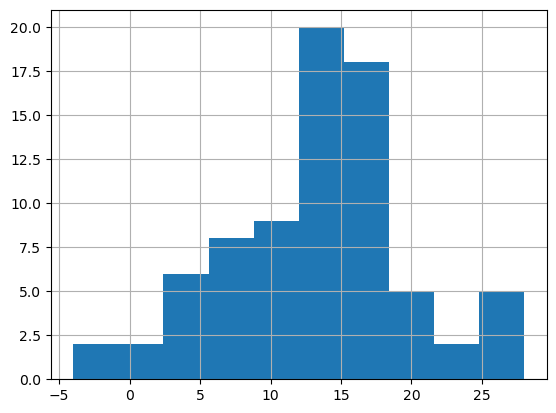

In [53]:
df['HDRS21_Improvement'].hist()

In [54]:
median_value

14.0

In [55]:
subject = 'subject'
label = 'above_median_HDRS21_Improvement'

best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=42)

In [56]:
original_df_label_ratio

0.0    0.558442
1.0    0.441558
Name: above_median_HDRS21_Improvement, dtype: float64

In [57]:
best_split_label_ratio

0.0    0.533333
1.0    0.466667
Name: above_median_HDRS21_Improvement, dtype: float64

In [44]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.70)
    threshold_low = column_data.quantile(0.30)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

In [45]:
from sklearn.model_selection import GridSearchCV

models = ['XGBoost', 'RandomForest','Catboost','TPF','TPF_top3','TPF_top5','TPF_top7','TPF_top9','TPF_top11','TPF_top13','TPF_top15']
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
subject = 'subject'
label = 'above_median_HDRS21_Improvement'
combined_results = pd.DataFrame()

for model_name in models:
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    
    for i in range(1, 10):
        best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=i)
        best_train_df = filter_by_percentile(best_train_df,'HDRS21_Improvement')
        X_train = best_train_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
        X_test = best_test_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
        y_train = best_train_df["above_median_HDRS21_Improvement"]
        y_test = best_test_df["above_median_HDRS21_Improvement"]

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        if model_name == 'XGBoost':
            param_grid = {
                'n_estimators': [50],
                'max_depth': [6],
                'learning_rate': [ 0.1] 
                
            }
            model = XGBClassifier()
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(scaled_X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(scaled_X_test)
        elif model_name == 'RandomForest':
            param_grid = {
                'n_estimators': [50],
                'max_depth': [ 5],
                'max_features': ['sqrt']
            }
            model = RandomForestClassifier()
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(scaled_X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(scaled_X_test)
        elif model_name == 'Catboost':
            model = CatBoostClassifier(
                iterations=100,
                learning_rate=0.1,
                depth=6,
                l2_leaf_reg=1,
                random_strength=0.5,
                border_count=32,
                random_state=42
            )
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'TPF':
            y_pred = TPF_classifier(pd.DataFrame(scaled_X_train),y_train,pd.DataFrame(scaled_X_test),y_test)
        elif model_name == 'TPF_top3':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=3)
        elif model_name == 'TPF_top5':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=5)
        elif model_name == 'TPF_top7':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=7)
        elif model_name == 'TPF_top9':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=9)
        elif model_name == 'TPF_top11':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=11)
        elif model_name == 'TPF_top13':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=13)
        elif model_name == 'TPF_top15':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=15)
            
        pred_acc = accuracy_score(y_test, y_pred)
        pred_sensitivity = recall_score(y_test, y_pred)
        pred_specificity = recall_score(y_test, y_pred, pos_label = 0)
        

        accuracy_scores.append(pred_acc)
        sensitivity_scores.append(pred_sensitivity)
        specificity_scores.append(pred_specificity)

    mean_acc = np.mean(accuracy_scores)
    mean_sensitivity = np.mean(sensitivity_scores)
    mean_specificity = np.mean(specificity_scores)
    
    std_acc = np.std(accuracy_scores)
    std_sensitivity = np.std(sensitivity_scores)
    std_specificity = np.std(specificity_scores)
    
    
    model_results = {
        'Model': model_name,
        'Accuracy': f"{mean_acc:.2f} ± {std_acc:.2f}",
        'Sensitivity': f"{mean_sensitivity:.2f} ± {std_sensitivity:.2f}",
        'Specificity': f"{mean_specificity:.2f} ± {std_specificity:.2f}",
        
    }
    
    model_row = pd.DataFrame(model_results, index=[0])
    combined_results = pd.concat([combined_results, model_row])

# Reset index of combined_results DataFrame
combined_results.reset_index(drop=True, inplace=True)



0:	learn: 0.5654851	total: 10.3ms	remaining: 1.02s
1:	learn: 0.4819168	total: 19.7ms	remaining: 965ms
2:	learn: 0.4030041	total: 28.7ms	remaining: 927ms
3:	learn: 0.3392860	total: 37.5ms	remaining: 901ms
4:	learn: 0.2899001	total: 46.6ms	remaining: 886ms
5:	learn: 0.2494229	total: 60.5ms	remaining: 949ms
6:	learn: 0.2163435	total: 70ms	remaining: 930ms
7:	learn: 0.1904309	total: 79.1ms	remaining: 909ms
8:	learn: 0.1615166	total: 93.5ms	remaining: 945ms
9:	learn: 0.1447687	total: 102ms	remaining: 922ms
10:	learn: 0.1288618	total: 111ms	remaining: 901ms
11:	learn: 0.1181307	total: 120ms	remaining: 879ms
12:	learn: 0.1039926	total: 129ms	remaining: 861ms
13:	learn: 0.0947966	total: 137ms	remaining: 842ms
14:	learn: 0.0852094	total: 146ms	remaining: 826ms
15:	learn: 0.0808665	total: 155ms	remaining: 814ms
16:	learn: 0.0734021	total: 165ms	remaining: 804ms
17:	learn: 0.0679593	total: 174ms	remaining: 791ms
18:	learn: 0.0621249	total: 183ms	remaining: 778ms
19:	learn: 0.0580212	total: 191ms	

66:	learn: 0.0096297	total: 641ms	remaining: 316ms
67:	learn: 0.0094723	total: 650ms	remaining: 306ms
68:	learn: 0.0092570	total: 656ms	remaining: 295ms
69:	learn: 0.0090662	total: 666ms	remaining: 285ms
70:	learn: 0.0088985	total: 676ms	remaining: 276ms
71:	learn: 0.0087084	total: 683ms	remaining: 265ms
72:	learn: 0.0085211	total: 689ms	remaining: 255ms
73:	learn: 0.0083806	total: 696ms	remaining: 245ms
74:	learn: 0.0082449	total: 704ms	remaining: 235ms
75:	learn: 0.0080951	total: 712ms	remaining: 225ms
76:	learn: 0.0079404	total: 720ms	remaining: 215ms
77:	learn: 0.0077996	total: 728ms	remaining: 205ms
78:	learn: 0.0076533	total: 734ms	remaining: 195ms
79:	learn: 0.0075225	total: 740ms	remaining: 185ms
80:	learn: 0.0073900	total: 745ms	remaining: 175ms
81:	learn: 0.0072524	total: 751ms	remaining: 165ms
82:	learn: 0.0071353	total: 757ms	remaining: 155ms
83:	learn: 0.0070227	total: 763ms	remaining: 145ms
84:	learn: 0.0069028	total: 770ms	remaining: 136ms
85:	learn: 0.0067924	total: 775

27:	learn: 0.0373554	total: 268ms	remaining: 689ms
28:	learn: 0.0346473	total: 275ms	remaining: 674ms
29:	learn: 0.0329036	total: 286ms	remaining: 667ms
30:	learn: 0.0313604	total: 295ms	remaining: 656ms
31:	learn: 0.0296025	total: 304ms	remaining: 645ms
32:	learn: 0.0282690	total: 314ms	remaining: 637ms
33:	learn: 0.0271425	total: 323ms	remaining: 627ms
34:	learn: 0.0258517	total: 332ms	remaining: 616ms
35:	learn: 0.0249590	total: 340ms	remaining: 604ms
36:	learn: 0.0239345	total: 349ms	remaining: 595ms
37:	learn: 0.0231709	total: 357ms	remaining: 583ms
38:	learn: 0.0225754	total: 366ms	remaining: 573ms
39:	learn: 0.0216661	total: 375ms	remaining: 563ms
40:	learn: 0.0211196	total: 384ms	remaining: 552ms
41:	learn: 0.0202198	total: 393ms	remaining: 542ms
42:	learn: 0.0195277	total: 401ms	remaining: 532ms
43:	learn: 0.0188869	total: 409ms	remaining: 521ms
44:	learn: 0.0182786	total: 418ms	remaining: 511ms
45:	learn: 0.0176030	total: 428ms	remaining: 502ms
46:	learn: 0.0170202	total: 436

0:	learn: 0.5889092	total: 9.43ms	remaining: 934ms
1:	learn: 0.4959751	total: 18ms	remaining: 883ms
2:	learn: 0.4140320	total: 26.2ms	remaining: 846ms
3:	learn: 0.3573512	total: 34.6ms	remaining: 831ms
4:	learn: 0.3047421	total: 42.6ms	remaining: 810ms
5:	learn: 0.2647968	total: 50.6ms	remaining: 793ms
6:	learn: 0.2275583	total: 58.5ms	remaining: 777ms
7:	learn: 0.1934680	total: 66.5ms	remaining: 765ms
8:	learn: 0.1698298	total: 72.3ms	remaining: 731ms
9:	learn: 0.1497619	total: 80.4ms	remaining: 723ms
10:	learn: 0.1335934	total: 89.1ms	remaining: 721ms
11:	learn: 0.1142075	total: 95ms	remaining: 697ms
12:	learn: 0.1050485	total: 103ms	remaining: 689ms
13:	learn: 0.0894768	total: 109ms	remaining: 668ms
14:	learn: 0.0832999	total: 117ms	remaining: 661ms
15:	learn: 0.0757726	total: 125ms	remaining: 655ms
16:	learn: 0.0697471	total: 133ms	remaining: 648ms
17:	learn: 0.0639952	total: 141ms	remaining: 640ms
18:	learn: 0.0591608	total: 149ms	remaining: 633ms
19:	learn: 0.0546812	total: 156ms

76:	learn: 0.0074319	total: 551ms	remaining: 165ms
77:	learn: 0.0073129	total: 562ms	remaining: 159ms
78:	learn: 0.0071962	total: 575ms	remaining: 153ms
79:	learn: 0.0070940	total: 585ms	remaining: 146ms
80:	learn: 0.0069848	total: 594ms	remaining: 139ms
81:	learn: 0.0068750	total: 602ms	remaining: 132ms
82:	learn: 0.0067738	total: 609ms	remaining: 125ms
83:	learn: 0.0066705	total: 616ms	remaining: 117ms
84:	learn: 0.0065925	total: 624ms	remaining: 110ms
85:	learn: 0.0064958	total: 631ms	remaining: 103ms
86:	learn: 0.0064062	total: 638ms	remaining: 95.3ms
87:	learn: 0.0063143	total: 645ms	remaining: 87.9ms
88:	learn: 0.0062223	total: 652ms	remaining: 80.6ms
89:	learn: 0.0061420	total: 659ms	remaining: 73.3ms
90:	learn: 0.0060550	total: 666ms	remaining: 65.9ms
91:	learn: 0.0059705	total: 674ms	remaining: 58.6ms
92:	learn: 0.0058907	total: 681ms	remaining: 51.3ms
93:	learn: 0.0058123	total: 689ms	remaining: 43.9ms
94:	learn: 0.0057352	total: 696ms	remaining: 36.6ms
95:	learn: 0.0056604	t

50:	learn: 0.0138276	total: 366ms	remaining: 351ms
51:	learn: 0.0133415	total: 374ms	remaining: 346ms
52:	learn: 0.0129893	total: 382ms	remaining: 339ms
53:	learn: 0.0125418	total: 390ms	remaining: 332ms
54:	learn: 0.0122633	total: 397ms	remaining: 325ms
55:	learn: 0.0118874	total: 404ms	remaining: 318ms
56:	learn: 0.0115755	total: 411ms	remaining: 310ms
57:	learn: 0.0112536	total: 419ms	remaining: 303ms
58:	learn: 0.0110453	total: 426ms	remaining: 296ms
59:	learn: 0.0108437	total: 433ms	remaining: 288ms
60:	learn: 0.0105662	total: 439ms	remaining: 281ms
61:	learn: 0.0103261	total: 446ms	remaining: 274ms
62:	learn: 0.0101359	total: 454ms	remaining: 266ms
63:	learn: 0.0098501	total: 461ms	remaining: 259ms
64:	learn: 0.0096044	total: 468ms	remaining: 252ms
65:	learn: 0.0094347	total: 476ms	remaining: 245ms
66:	learn: 0.0092376	total: 483ms	remaining: 238ms
67:	learn: 0.0090846	total: 490ms	remaining: 231ms
68:	learn: 0.0088502	total: 497ms	remaining: 224ms
69:	learn: 0.0087114	total: 505

In [46]:
combined_results

,Model,Accuracy,Sensitivity,Specificity
0,XGBoost,0.57 ± 0.15,0.42 ± 0.17,0.71 ± 0.30
1,RandomForest,0.51 ± 0.14,0.38 ± 0.20,0.64 ± 0.23
2,Catboost,0.60 ± 0.17,0.47 ± 0.13,0.73 ± 0.33
3,TPF,0.43 ± 0.12,0.42 ± 0.17,0.44 ± 0.28
4,TPF_top3,0.47 ± 0.12,0.33 ± 0.25,0.60 ± 0.21
5,TPF_top5,0.44 ± 0.15,0.31 ± 0.14,0.58 ± 0.26
6,TPF_top7,0.43 ± 0.11,0.29 ± 0.14,0.58 ± 0.26
7,TPF_top9,0.51 ± 0.12,0.44 ± 0.18,0.58 ± 0.26
8,TPF_top11,0.51 ± 0.18,0.42 ± 0.22,0.60 ± 0.28
9,TPF_top13,0.52 ± 0.20,0.42 ± 0.24,0.62 ± 0.33


In [49]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H1\result_tables\H1_full_above_median_HDRS21_imrovement_filtered_percent_ASS.csv")

26

13.0